# Clasificación de Tardígrados con ResNet50 y Transfer Learning

Este notebook utiliza la arquitectura **ResNet50**, un modelo preentrenado en el conjunto de datos **ImageNet**, para realizar la clasificación de imágenes de tardígrados. A través de transfer learning, adaptamos la red a nuestro conjunto de datos para identificar y clasificar imágenes en dos categorías.

El flujo del notebook incluye:
1. Carga del modelo preentrenado **ResNet50**.
2. Construcción de una red personalizada con capas adicionales.
3. Preprocesamiento de imágenes y generación de datos de entrenamiento y validación.
4. Entrenamiento del modelo y evaluación de su desempeño.

In [ ]:
import numpy as np
import keras
from keras import layers
import matplotlib.pyplot as plt

In [ ]:
# prompt: drive mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# prompt: drive mount

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Carga del Modelo Base: ResNet50
Utilizamos **ResNet50**, un modelo ampliamente utilizado en tareas de visión por computadora. Este modelo está preentrenado en el conjunto de datos **ImageNet**, lo que nos permite aprovechar las características aprendidas por las capas profundas del modelo y adaptarlas a nuestra tarea específica.

- `weights='imagenet'`: Carga los pesos preentrenados del modelo.
- `include_top=False`: Excluye las capas de clasificación originales del modelo para permitir la personalización.
- `input_shape=(224, 224, 3)`: Especifica el tamaño de las imágenes de entrada (224x224 píxeles con 3 canales RGB).


In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


## Congelación de las Capas del Modelo Base
Para evitar el sobreajuste y reducir el tiempo de entrenamiento, congelamos las capas del modelo base. Esto significa que los pesos de estas capas no serán actualizados durante el entrenamiento, y únicamente entrenaremos las capas adicionales que agregamos.


In [ ]:
for layer in base_model.layers:
    layer.trainable = False


## Construcción de la Red Personalizada
Agregamos capas adicionales al modelo base para adaptarlo a nuestro problema de clasificación:

1. **GlobalAveragePooling2D()**: Reduce la dimensionalidad de las características generadas por el modelo base.
2. **Dense(1024, activation='relu')**: Una capa completamente conectada con 1024 neuronas y activación ReLU.
3. **Dropout(0.5)**: Apaga aleatoriamente el 50% de las neuronas durante el entrenamiento para prevenir el sobreajuste.
4. **Dense(2, activation='softmax')**: Capa de salida con 2 neuronas (una por categoría) y activación softmax para probabilidades.

### Optimización y Métrica
El modelo se compila con:
- Optimizador: `adam`
- Pérdida: `categorical_crossentropy` (para clasificación categórica).
- Métrica: `accuracy`.


In [ ]:
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(2, activation='softmax')
])


In [ ]:
#from tensorflow.keras import layers, models

#model = models.Sequential([
#    base_model,
 #   layers.GlobalAveragePooling2D(),
  #  layers.Dense(1024, activation='relu'),
   # layers.Dropout(0.5),
  #  layers.Dense(512, activation='relu'),  # Nueva capa adicional
  #  layers.Dense(2, activation='softmax')  # num_classes es el número de categorías en tu dataset
#])


Compilación del modelo

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


## Generación de Datos de Entrenamiento y Validación
Utilizamos la clase `ImageDataGenerator` para:
1. **Preprocesar las imágenes**: Escalamos los valores de los píxeles entre 0 y 1 (`rescale=1./255`).
2. **Aumentar los datos**: Aplicamos técnicas de aumento para reducir el sobreajuste, como:
   - Rotaciones aleatorias (`rotation_range=20`).
   - Desplazamientos horizontales y verticales (`width_shift_range=0.2`, `height_shift_range=0.2`).
   - Zoom aleatorio (`zoom_range=0.2`).
   - Volteo horizontal (`horizontal_flip=True`).

### División de Datos
- **Conjunto de entrenamiento**: 80% de las imágenes (`subset='training'`).
- **Conjunto de validación**: 20% de las imágenes (`subset='validation'`).

Las imágenes se ajustan al tamaño de entrada esperado por ResNet50 (`target_size=(224, 224)`) y se cargan en lotes de tamaño 32.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_size = (224, 224)
batch_size = 32


datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80% entrenamiento, 20% validación
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

# Gen train
train_data = datagen.flow_from_directory(
    '/content/drive/MyDrive/DataScience/TardisImages/tardis',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

# Gen Val
val_data = datagen.flow_from_directory(
    '/content/drive/MyDrive/DataScience/TardisImages/tardis',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)


Found 311 images belonging to 2 classes.
Found 77 images belonging to 2 classes.


## Entrenamiento del Modelo

En esta sección, entrenamos el modelo construido utilizando los datos de entrenamiento y validación previamente generados.

### Parámetros del entrenamiento:
- **Datos de entrenamiento (`train_data`)**: Imágenes preprocesadas con aumentos para mejorar la generalización del modelo.
- **Épocas (`epochs=20`)**: El modelo pasará 20 veces por todo el conjunto de datos de entrenamiento.
- **Datos de validación (`validation_data=val_data`)**: Se utilizan para evaluar el rendimiento del modelo al final de cada época, proporcionando métricas como la precisión y pérdida en datos que el modelo no ha visto.

El objetivo del entrenamiento es minimizar la función de pérdida (`categorical_crossentropy`) mientras se optimizan los pesos del modelo utilizando el algoritmo `Adam`.


In [ ]:
history = model.fit(train_data, epochs=20, validation_data=val_data)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/10 ━━━━━━━━━━━━━━━━━━━━ 192s 9s/step - accuracy: 0.4279 - loss: 1.6277 - val_accuracy: 0.4935 - val_loss: 1.0388
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step - accuracy: 0.5161 - loss: 0.8912 - val_accuracy: 0.4935 - val_loss: 0.6548
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 963ms/step - accuracy: 0.5402 - loss: 0.7479 - val_accuracy: 0.4935 - val_loss: 0.6087
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5999 - loss: 0.7166 - val_accuracy: 0.8312 - val_loss: 0.5896
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 40s 862ms/step - accuracy: 0.5745 - loss: 0.7078 - val_accuracy: 0.6753 - val_loss: 0.5947
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5766 - loss: 0.7045 - val_accuracy: 0.6883 - val_loss: 0.5848
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.5698 - loss: 0.6900 - val_accuracy: 0.7013 - val_loss: 0.5808
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.5913 - loss: 0.6603 - val_accuracy: 0.6364 - val_loss: 0.6

## Evaluación del Modelo en el Conjunto de Validación

En esta sección, evaluamos el rendimiento del modelo utilizando el conjunto de datos de validación.

### Propósito:
- **`model.evaluate(val_data)`** calcula dos métricas clave:
  - **`val_loss`**: Representa la pérdida en los datos de validación, lo cual indica qué tan bien el modelo predice las etiquetas correctas en datos no vistos.
  - **`val_accuracy`**: Indica la proporción de predicciones correctas realizadas por el modelo en el conjunto de validación.

### Objetivo:
El objetivo es verificar si el modelo generaliza bien en datos nuevos. Un valor bajo de `val_loss` y un valor alto de `val_accuracy` indican que el modelo tiene un buen rendimiento en el conjunto de validación.


In [ ]:
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")


3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7633 - loss: 0.5445
Validation Loss: 0.5382950305938721
Validation Accuracy: 0.7532467246055603


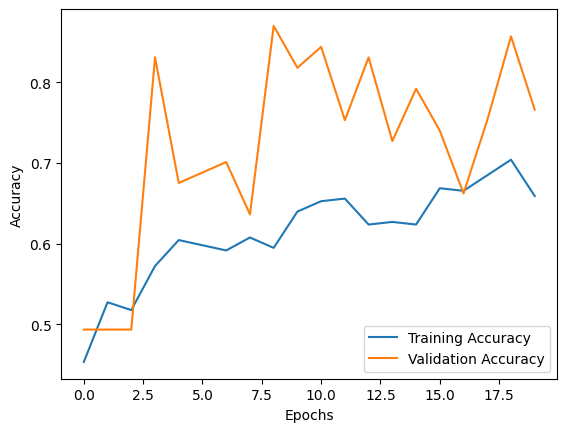

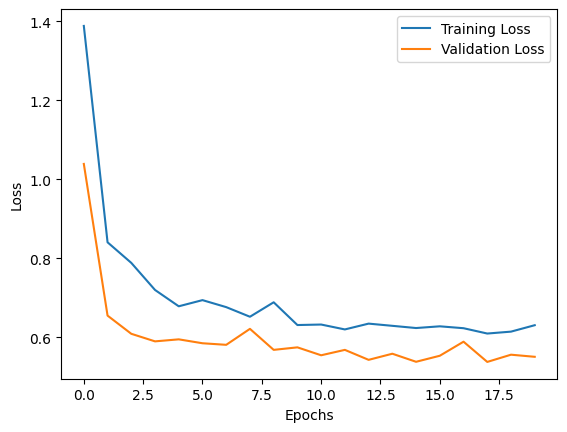

In [ ]:
import matplotlib.pyplot as plt


plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


## Evaluación Detallada del Modelo: Reporte de Clasificación y Matriz de Confusión

En esta sección, generamos métricas detalladas para evaluar el rendimiento del modelo, más allá de la precisión y la pérdida. Utilizamos las siguientes herramientas:

1. **Reporte de Clasificación (`classification_report`)**:
   - Proporciona métricas clave para cada clase, como:
     - **Precisión** (*Precision*): Proporción de predicciones correctas para una clase específica.
     - **Sensibilidad** (*Recall*): Proporción de instancias de una clase que fueron correctamente identificadas.
     - **F1-Score**: Media armónica entre precisión y sensibilidad, útil para evaluar el equilibrio entre ambas.

2. **Matriz de Confusión (`confusion_matrix`)**:
   - Una tabla que muestra el número de predicciones correctas e incorrectas clasificadas por clase.
   - Ayuda a identificar patrones de error específicos, como confusiones frecuentes entre dos clases.

### Pasos:
- Obtenemos las etiquetas verdaderas (`y_true`) del conjunto de validación.
- Generamos las predicciones del modelo (`y_pred`) utilizando el conjunto de validación.
- Comparamos `y_true` con `y_pred` para calcular las métricas.

Este análisis es crucial para comprender cómo se comporta el modelo con cada clase y detectar áreas de mejora.


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


y_true = val_data.classes
y_pred = np.argmax(model.predict(val_data), axis=-1)


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=val_data.class_indices.keys()))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 3s/step
Classification Report:
                  precision    recall  f1-score   support

    eutardigrada       0.53      0.72      0.61        39
heterotardigrada       0.54      0.34      0.42        38

        accuracy                           0.53        77
       macro avg       0.53      0.53      0.51        77
    weighted avg       0.53      0.53      0.52        77

Confusion Matrix:
[[28 11]
 [25 13]]


## Ajuste Fino del Modelo Preentrenado (Fine-Tuning)

En esta sección, habilitamos el ajuste fino del modelo preentrenado **ResNet50** para mejorar su desempeño en nuestro conjunto de datos. Esto significa que algunas capas del modelo base ahora serán entrenables, lo que permite que el modelo ajuste los pesos previamente aprendidos de manera específica para nuestra tarea.

### Pasos realizados:

1. **Activación del entrenamiento en capas superiores del modelo base:**
   - **`base_model.trainable = True`**: Hacemos que el modelo base sea entrenable.
   - **Congelación parcial de capas:** Solo entrenamos las capas superiores del modelo, mientras que las capas inferiores permanecen congeladas.
   - Este enfoque evita sobreajustar las capas iniciales, que generalmente capturan características generales útiles para muchas tareas de visión por computadora.

2. **Compilación del modelo con un optimizador ajustado:**
   - Utilizamos el optimizador **Adam**, que es robusto para ajustar pesos de manera eficiente.
   - **Tasa de aprendizaje baja (`learning_rate=1e-4`)**: Elegimos una tasa de aprendizaje más pequeña para realizar pequeños ajustes en las capas superiores sin modificar demasiado los pesos preentrenados.
   - La función de pérdida sigue siendo **`categorical_crossentropy`**, adecuada para clasificación categórica.
   - **Métricas:** Seguimos evaluando la precisión (`accuracy`) para monitorear el rendimiento durante el entrenamiento.



In [ ]:
base_model.trainable = True
for layer in base_model.layers[:50]:
    layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
class_weights = {0: 1.0, 1: 1.5}
history_finetune = model.fit(train_data, epochs=20, validation_data=val_data)

Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step - accuracy: 0.7175 - loss: 0.6239 - val_accuracy: 0.7662 - val_loss: 0.5393
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 26s 1s/step - accuracy: 0.6677 - loss: 0.6481 - val_accuracy: 0.7792 - val_loss: 0.5283
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.6689 - loss: 0.5910 - val_accuracy: 0.7922 - val_loss: 0.5241
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.7014 - loss: 0.6108 - val_accuracy: 0.7922 - val_loss: 0.5138
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 41s 1s/step - accuracy: 0.7200 - loss: 0.5878 - val_accuracy: 0.8312 - val_loss: 0.5134
Epoch 6/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 21s 913ms/step - accuracy: 0.7219 - loss: 0.5775 - val_accuracy: 0.7273 - val_loss: 0.5316
Epoch 7/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 23s 1s/step - accuracy: 0.6754 - loss: 0.5982 - val_accuracy: 0.7792 - val_loss: 0.5103
Epoch 8/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step - accuracy: 0.6838 - loss: 0.6094 - val_accuracy: 0.8182 - val_lo

In [ ]:
val_loss, val_accuracy = model.evaluate(val_data)
print(f"Validation Loss: {val_loss}")
print(f"Validation Accuracy: {val_accuracy}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8257 - loss: 0.4934
Validation Loss: 0.49249574542045593
Validation Accuracy: 0.8311688303947449


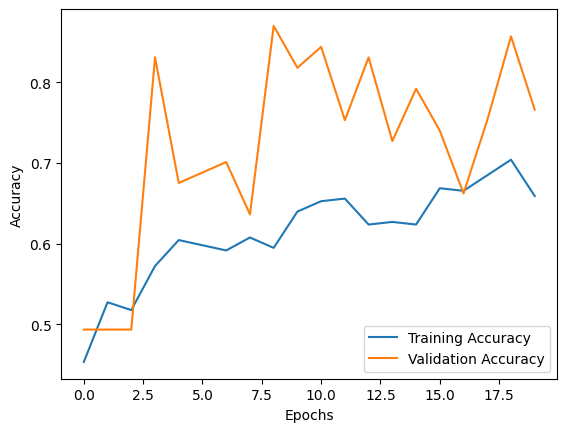

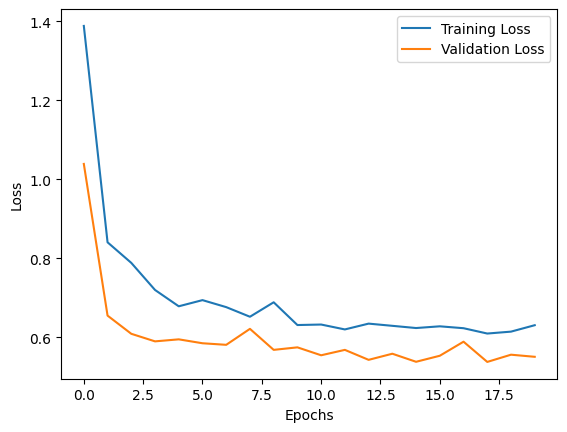

In [ ]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix


y_true = val_data.classes
y_pred = np.argmax(model.predict(val_data), axis=-1)


print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=val_data.class_indices.keys()))

print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
Classification Report:
                  precision    recall  f1-score   support

    eutardigrada       0.59      0.77      0.67        39
heterotardigrada       0.65      0.45      0.53        38

        accuracy                           0.61        77
       macro avg       0.62      0.61      0.60        77
    weighted avg       0.62      0.61      0.60        77

Confusion Matrix:
[[30  9]
 [21 17]]
